**任务时间：题目1-3（11.05-11.10）
题目4、5（11.12-11.17）
题目6（11.19-11.25）**

**互评与筛选时间：题目1-3（11.11）
题目4、5（11.18）
题目6（11.26）**

每周只用提交相应的部分到自己的git，试题实行每周淘汰制

新互评链接：https://yiqixie.com/s/home/fcACT-kZRz10FXWBU2jXDt8VO

# 1、成功读取BTCUSDT:binance的数据，绘出30Min和1H的gap图

'start_date':20180601000000

In [58]:
import warnings

warnings.filterwarnings('ignore')

In [59]:
from jaqs_fxdayu.data.dataservice import LocalDataService

ds = LocalDataService()

## 加freq参数
path = r'../min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'BTCUSDT:binance',
         'freq': '30Min,1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据

In [60]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv30M = HFDataView()
dv1H = HFDataView()
dv30M.create_init_dv(Time_dict['30Min'].dropna().set_index(["trade_date","symbol"]))
dv1H.create_init_dv(Time_dict['1H'].dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.
Initialize dataview success.


In [61]:
Gap30 = dv30M.add_formula('gap', 'close-Delay(open, 1)',add_data=True)
Gap1H = dv1H.add_formula('gap', 'close-Delay(open, 1)',add_data=True)

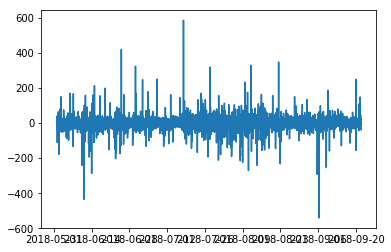

In [62]:
#30Min的图
import matplotlib.pyplot as plt
plt.plot(dv30M.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])
plt.show()

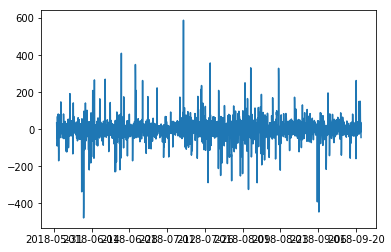

In [63]:
#1H的图
import matplotlib.pyplot as plt
plt.plot(dv1H.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])
plt.show()

# 2、调用alpha101research中的alpha10进行绘图，定义事件，打印绩效

要求：

1、绘出alpha10_dv30M_ma5_ma20、alpha10_dv1H_ma5_ma20的图。

2、定义alpha10的金叉死叉事件，周期为20和55，并打印出long_short的绩效

In [64]:
#定义alpha10信号

for dvAdd in [dv30M, dv1H]:
    dvAdd.add_formula('alpha10_C','If(Ts_Min(Delta(close,1),4)>0,Delta(close,1),If((Ts_Max(Delta(close,1),4)<0),Delta(close,1),(-1*Delta(close,1))))',add_data=True)

In [65]:
#定义绘图函数
import matplotlib.pyplot as plt

def Plot_Mean(dv, alpha, chart_name='dv_alpha_ma', ShortPeriod=20, LongPeriod=60, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
#     plt.savefig(chart_name)
    plt.show()

In [83]:
dv_dict = {'alpha10_dv30M':dv30M, 'alpha10_dv1H':dv1H}
alpha1_dict = {n: dv.get_ts('alpha10_C', date_type='datetime') for n, dv in dv_dict.items()}

#import pandas as pd
#for name, alpha in alpha1_dict.items():
#    Plot_Mean(globals()[name.split('_')[1]], alpha.iloc[:,0], chart_name=name+'_ma5_ma20',ShortPeriod=5, LongPeriod=20, n=-1000)#橘色短线 绿色长线
#alpha1_dict
for n, dv in dv_dict.items():
    print(n,dv)
alpha = dv30M.get_ts('alpha10_C', date_type='datetime').iloc[:,0]
type(alpha)
alpha1 = dv30M.get_ts('alpha10_C', date_type='datetime')
type(alpha1)

alpha10_dv30M <jaqs_fxdayu.data.hf_dataview.HFDataView object at 0x000001916F6AD208>
alpha10_dv1H <jaqs_fxdayu.data.hf_dataview.HFDataView object at 0x000001916F6ADFD0>


pandas.core.frame.DataFrame

In [14]:
# 进场信号
long = dv1H.add_formula("longAlpha10","If((Ts_Mean(alpha10_C,20)>Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)<=Delay(Ts_Mean(alpha10_C,55),1)),2,0)", add_data=True)
short = dv1H.add_formula("shortAlpha10","If((Ts_Mean(alpha10_C,20)<Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)>=Delay(Ts_Mean(alpha10_C,55),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLongAlpha10","If(shortAlpha10==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShortAlpha10","If(longAlpha10==2,-1,0)", add_data=True)

dv1H.get_ts('longAlpha10').stack()[dv1H.get_ts('longAlpha10').stack()==2].tail()

Field [longAlpha10] is overwritten.
Field [shortAlpha10] is overwritten.
Field [closeLongAlpha10] is overwritten.
Field [closeShortAlpha10] is overwritten.


trade_date      symbol         
20180919050000  BTCUSDT:binance    2.0
20180919080000  BTCUSDT:binance    2.0
20180919110000  BTCUSDT:binance    2.0
20180919160000  BTCUSDT:binance    2.0
20180920230000  BTCUSDT:binance    2.0
dtype: float64

In [17]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

tdMa = TimingDigger(output_folder=".", output_format='pdf',signal_name='Ma')

def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

from jaqs_fxdayu.research import TimingDigger

tdAlpha10 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha10')

TimingSignal(tdAlpha10, dv1H,'longAlpha10','shortAlpha10','closeLongAlpha10','closeShortAlpha10', 100, 0.05, 0.3)

tdAlpha10.create_event_report(sig_type="long_short")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                8.290   -9.095   -0.145
p-value               0.000    0.000    0.885
mean                  0.011   -0.011   -0.000
std                   0.016    0.015    0.019
info_ratio            0.677   -0.738   -0.008
skewness              3.664   -1.974    0.697
kurtosis             17.554    2.909    8.470
pct5                  0.001   -0.049   -0.032
pct25                 0.002   -0.012   -0.005
pct50                 0.005   -0.005   -0.000
pct75                 0.012   -0.002    0.005
pct95                 0.041   -0.001    0.027
occurance           151.000  153.000  304.000
win_ratio               NaN      NaN    0.497
win_mean/loss_mean      NaN      NaN    0.984


# 3、打印出Morningstar事件的时间点，绘出Morningstar与成交量的图

数据类型要求：'symbol': 'BTCUSDT:binance',

'freq': '1H','start_date':20180601000000

In [18]:
import warnings
warnings.filterwarnings('ignore')
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
start = time()

path = r'../min_data/VnTrader_1Min_Db'
props = {'fields':'open,high,low,close,volume',
         'symbol': 'BTCUSDT:binance',
        'freq': '1H',
        'start_date':20180601000000}
Time_dict = ds.bar_reader(path,props)
dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.


In [19]:
morningstar = dv1H.add_formula('morningstar',"If((Ta('CDLMORNINGSTAR', 0, open, high, low, close, volume)==100),100,0)", add_data=True)
morningstarVolume = dv1H.get_ts('morningstar', date_type='datetime')
morningstarVolume[morningstarVolume['BTCUSDT:binance']==100]

symbol,BTCUSDT:binance
trade_date,
2018-06-15 22:00:00,100.0
2018-07-12 11:00:00,100.0
2018-07-19 06:00:00,100.0
2018-08-09 17:00:00,100.0
2018-08-31 04:00:00,100.0
2018-09-11 02:00:00,100.0
2018-09-18 01:00:00,100.0
2018-09-19 09:00:00,100.0


In [20]:
from matplotlib.pylab import date2num
Time_dict = ds.bar_reader(path,props)
data1H = Time_dict.set_index('datetime')

data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

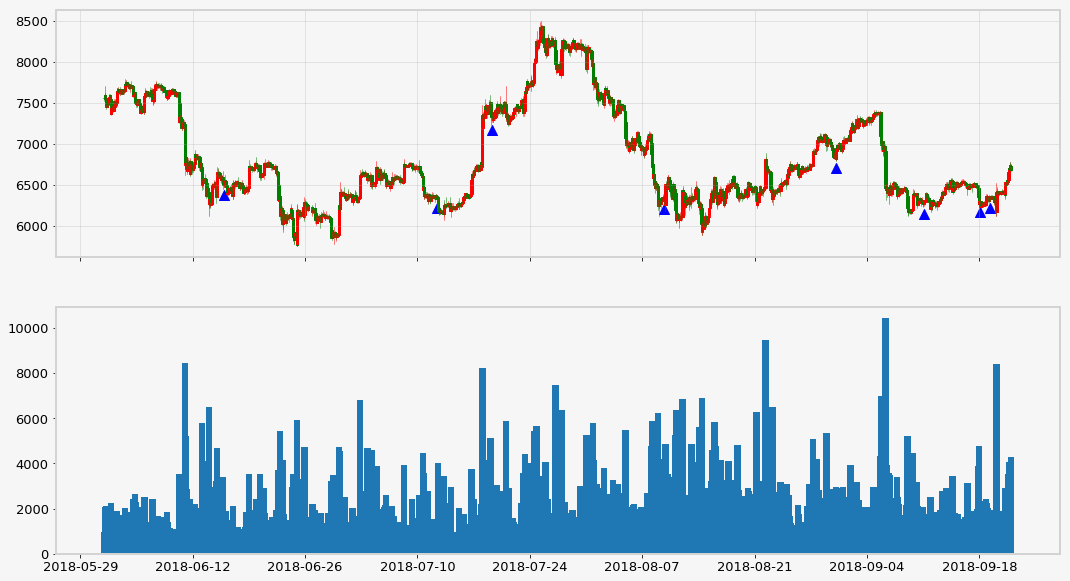

In [23]:
import mpl_finance as mpf
morningstarVolumeX = morningstarVolume[morningstarVolume['BTCUSDT:binance']==100].index

morningstarVolumeY = data1H.loc[morningstarVolumeX].low-100
def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()
draw_candle(candle, morningstarVolumeX, morningstarVolumeY)

# 4、调用alpha101、alpha191、技术因子、candleresearch或者自己创造衍生因子，要求：任意两个因子，进行画图观察，主要例子看alpha101research和candleresearch，写研究报告（画了什么因子，思考了什么现象，对现象进行描述）


https://github.com/ChannelCMT/formula/wiki

数据类型和周期自定


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
    #读取数据
    from jaqs_fxdayu.data.dataservice import LocalDataService
    from jaqs_fxdayu.data.hf_dataview import HFDataView
    ds = LocalDataService()
    path = r'../min_data/VnTrader_1Min_Db'
    props = {'fields': 'open,high,low,close,volume',
             'symbol': 'BTCUSDT:binance',
             'freq': '1H',
             'start_date':20180601000000}
    Time_dict = ds.bar_reader(path,props)

    dv = HFDataView()
    dv.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.


In [128]:
#定义第一个因子MACD
dv.add_formula('EMA12', "Ta('EMA',0,0,0,0,close,0,12)", add_data = True);
dv.add_formula('EMA26', "Ta('EMA',0,0,0,0,close,0,26)", add_data = True);
dv.add_formula('DIF', "EMA12 - EMA26", add_data = True);
dv.add_formula('DEA', "Ta('EMA',0,0,0,0,DIF,9)", add_data = True);
dv.add_formula('MACD', "2*(DIF-DEA)", add_data = True);

Field [EMA12] is overwritten.
Field [EMA26] is overwritten.
Field [DIF] is overwritten.
Field [DEA] is overwritten.
Field [MACD] is overwritten.


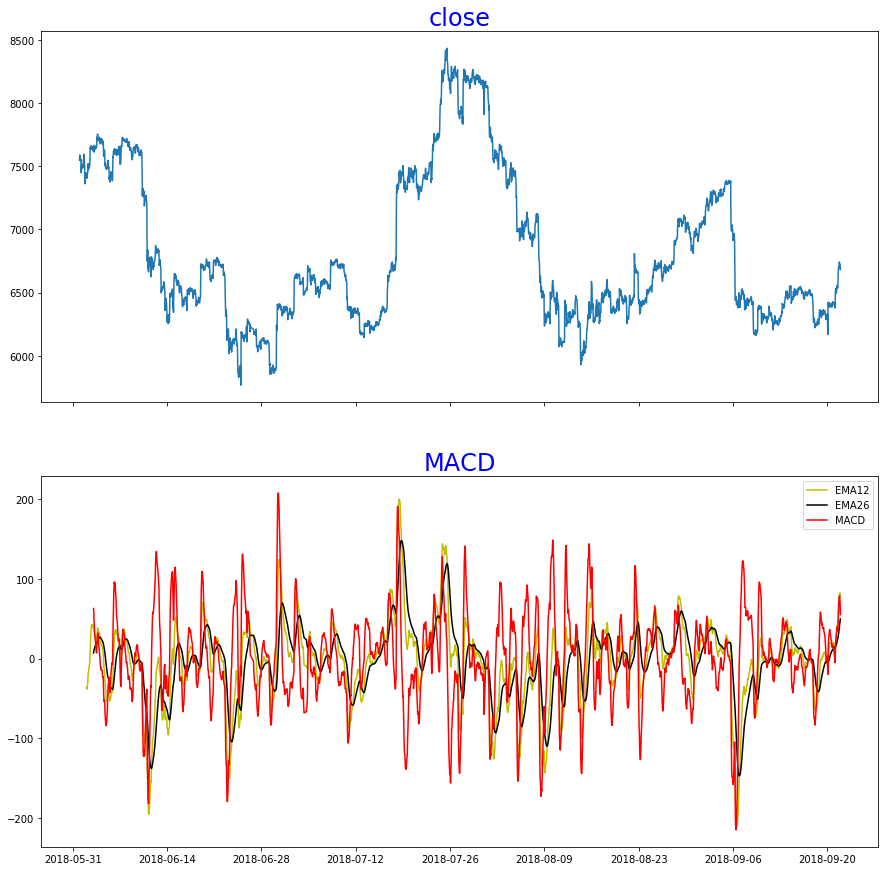

In [135]:
#对MACD绘图
import matplotlib.pyplot as plt
import pandas as pd
fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0])
ax.set_title('close',fontsize=24,color='b') 
ax1.plot(dv.get_ts('DIF', date_type='datetime').iloc[:,0],'y',label='EMA12')
ax1.plot(dv.get_ts('DEA', date_type='datetime').iloc[:,0],'k',label='EMA26')
ax1.plot(dv.get_ts('MACD', date_type='datetime').iloc[:,0],'r',label='MACD')
ax1.set_title('MACD',fontsize=24,color='b')
ax1.legend()
plt.show()

因子：
MACD指标是趋势类指标，反映了价格的变化趋势。相关中间变量的计算如下：
EMA12: 12日指数平均；
EMA26: 26日指数平均；
DIF：EMA12-EMA26；
DEA：DIF的9日指数平均；
MACD：2*（DIF-DEA）
DIF和MACD的值及线的位置
1、当DIF和MACD均大于0并向上移动时，一般表示为股市处于多头行情中，可以买入或持股；
2、当DIF和MACD均小于0并向下移动时，一般表示为股市处于空头行情中，可以卖出股票或观望。
3、当DIF和MACD均大于0但都向下移动时，一般表示为股票行情处于退潮阶段，股票将下跌，可以卖出股票和观望；
4、DIF和MACD均小于0时但向上移动时，一般表示为行情即将启动，股票将上涨，可以买进股票或持股待涨。
现象：
DIF趋势滞后；该均值趋势法可以采用金叉死叉思路进行进出场的判断信号。

In [1]:
#定义第二个因子,该因子无法用数学表达式表达，ANN模型进行计算
#在定义第二个因子时，我们通过机器学习来进行判断次日的涨幅是否可以唱过5%，或者涨幅低于-5%。
#如果涨幅超过5%，则全仓买入；如果涨幅处于-5%~5%之间，则不调仓；如果涨幅小于-5%,则平仓
#选取的特征值是，前4日开高低收，成交量相当于除以各自平均值的大小
#判断标准是，Y=0，1,2.
#为避免使用未来函数，平均数仅采用训练组的平均数

#重新读取数据
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from jaqs_fxdayu.data.dataservice import LocalDataService
from jaqs_fxdayu.data.hf_dataview import HFDataView
ds = LocalDataService()
path = r'../min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'BTCUSDT:binance',
         'freq': '1D',
         'start_date':20180101000000}
Time_dict = ds.bar_reader(path,props)
dv = HFDataView()
dv.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.


In [2]:

#数据预处理
import numpy as np
data_open = dv.get_ts('open',date_type='datetime')['BTCUSDT:binance']
data_open.name = 'open'
data_open = data_open/data_open.mean()

data_high = dv.get_ts('high',date_type='datetime')['BTCUSDT:binance']
data_high.name = 'high'
data_high = data_high/data_high.iloc[0:200].mean()

data_low = dv.get_ts('low',date_type='datetime')['BTCUSDT:binance']
data_low.name = 'low'
data_low = data_low/data_low.iloc[0:200].mean()

data_close = dv.get_ts('close',date_type='datetime')['BTCUSDT:binance']
data_close.name = 'close'
data_close = data_close/data_close.iloc[0:200].mean()

data_volume = dv.get_ts('volume',date_type='datetime')['BTCUSDT:binance']
data_volume.name = 'volume'
data_volume = data_volume/data_volume.iloc[0:200].mean()

data_return = dv.get_ts('close',date_type='datetime')['BTCUSDT:binance'].pct_change()
data_return.name = 'return'

df = pd.concat([data_open, data_high, data_low, data_close, data_volume, data_return], axis = 1)
df = df.fillna(method='backfill')

In [138]:
#提取用于训练ANN的特征,共5*4 = 20个，放置在一个数组中
data_features = np.zeros((len(df)-4, 4, 5))
data_labels = np.zeros((len(df)-4))
up = 0.02
down = -0.02
for i in range(0, data_features.shape[0]):
    data_features[i] = [[df.iloc[i,0],df.iloc[i,1],df.iloc[i,2],df.iloc[i,3],df.iloc[i,4]],
                   [df.iloc[i+1,0],df.iloc[i+1,1],df.iloc[i+1,2],df.iloc[i+1,3],df.iloc[i+1,4]],
                   [df.iloc[i+2,0],df.iloc[i+2,1],df.iloc[i+2,2],df.iloc[i+2,3],df.iloc[i+2,4]],
                   [df.iloc[i+3,0],df.iloc[i+3,1],df.iloc[i+3,2],df.iloc[i+3,3],df.iloc[i+3,4]]
                   ]
    if df.iloc[i+4,5] > up:
        data_labels[i] = 2
    elif df.iloc[i+4,5] < down:
        data_labels[i] = 0
    else:
        data_labels[i] = 1

train_features = data_features[0:200]
train_labels = data_labels[0:200]

test_features = data_features[200:]
test_labels = data_labels[200:]


In [129]:
test_labels

array([2., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
       1., 0., 2., 1., 0., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1.,
       1., 2., 1., 1., 1., 2., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       2., 1., 1., 1., 0., 1., 1., 1., 2.])

In [161]:
#调用之前设计好的模型
new_model = keras.models.load_model('my_model.h5')
new_model.compile(optimizer=tf.train.AdamOptimizer(),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
test_loss, test_acc = new_model.evaluate(test_features, test_labels)
print('Test accuracy:', test_acc)

60/60 [==============================] - 1s 17ms/step
Test accuracy: 0.6833333293596904


In [162]:
#计算因子值，因子值为0,1,2的概率
import copy
predictions = model.predict(data_features)
actions = copy.deepcopy(predictions)
for i in range(0,predictions.shape[0]):
    actions[i,np.argmax(actions[i])] = 1 
print(actions[-60:])

[[0.2710084  1.         0.33199465]
 [0.26648143 1.         0.33920392]
 [0.2590059  1.         0.35403627]
 [0.25060475 1.         0.3570499 ]
 [0.23395893 1.         0.36449638]
 [0.2698283  1.         0.3439812 ]
 [0.27408424 1.         0.34297222]
 [0.28452113 1.         0.3307149 ]
 [0.27949032 1.         0.3344019 ]
 [0.2767415  1.         0.3453101 ]
 [0.26127517 1.         0.36017433]
 [0.24747595 1.         0.35265824]
 [0.26144308 1.         0.346399  ]
 [0.27044842 1.         0.34797016]
 [0.26398465 1.         0.33986285]
 [0.278979   1.         0.33720416]
 [0.26131976 1.         0.34765974]
 [0.25318524 1.         0.36532804]
 [0.23328881 1.         0.38243794]
 [0.21217887 0.39156508 1.        ]
 [0.22858663 1.         0.3646464 ]
 [0.21944459 1.         0.3875804 ]
 [0.22882648 0.37796775 1.        ]
 [0.23927422 1.         0.37195083]
 [0.21124874 0.3852008  1.        ]
 [0.22828382 1.         0.37163296]
 [0.2131823  1.         0.38557544]
 [0.22294094 1.         0.37

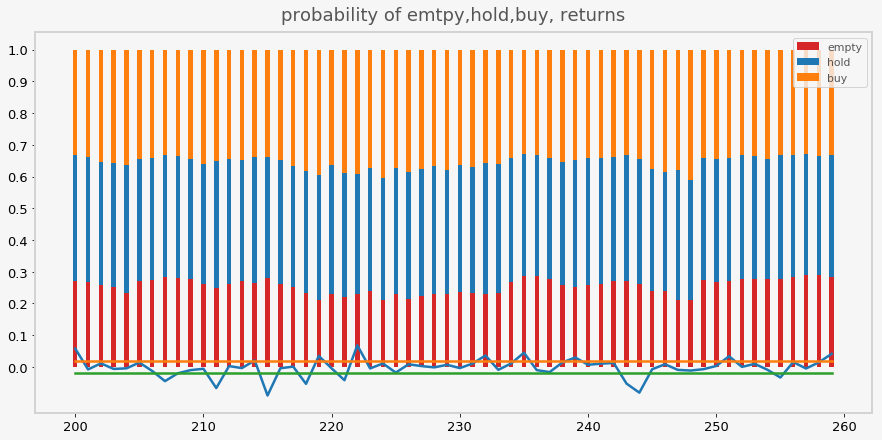

In [163]:
#观察后60天的预测结果对不对
import matplotlib.pyplot as plt
empty = predictions[-60:,0]
hold = predictions[-60:,1]
buy = predictions[-60:,2]
N = predictions.shape[0]
ind = np.arange(N)
width = 0.35
plt.figure(figsize=(15,7))
p1 = plt.bar(ind[-60:], empty, width, color='#d62728')
p2 = plt.bar(ind[-60:], hold, width,bottom=empty)
p3 = plt.bar(ind[-60:], buy, width,bottom=empty+hold)
plt.title('probability of emtpy,hold,buy, returns')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend((p1[0], p2[0], p3[0]), ('empty', 'hold', 'buy'))
plt.plot(ind[-60:],df['return'].iloc[-60:].values)
plt.plot(ind[-60:],np.ones(60)*up)
plt.plot(ind[-60:],np.ones(60)*down)
plt.show()

# 5、观察两个因子，和价格图有什么联系，如果是蜡烛图，和成交量有什么联系，怎么找到相应的信号，提出自己信号进出场的假设。（分别完成两个因子的信号假设）

信号进出场假设：可以借鉴MastatiscResearch，但不要将思路假设局限在均线上，可以观察大盘上的其他现象来写信号假设，也可以进行同时满足多个因子的信号来设计信号假设等等。

此处需要说出联系、找到的信号、你的信号进出场假设是什么

MACD信号

基于上述对MACD的分析，可以参考其意义定义下面的入场和出场条件
进场：当DIFF与DEA都在零线以上，DIFF向上突破DEA时，表明股市处于一种强势之中，股价将再次上涨，可以加码买进股票或持股待涨。
出场：当DIFF和DEA都在零线以下，DIFF向下突破DEA时，表明股市为弱势市场，股价跌势未止，应继续平仓持币。



ANN信号

ANN信号，通过将0.02的收益率进行设置，保证了0.7左右的识别率，该识别率较好。目前存在的问题是，当作为分类标准的涨跌幅阈值过大时，识别率会增高，但是进出场
结果基本为一直空仓，或者持仓，过于保守；当阈值减小时，识别率会下降，但是buy的操作相对来说会增加，有利于利用涨幅进行收入。
所以该ANN信号的关键，在于设立合理的涨跌幅阈值，来保证一定的识别正确率的同时，保证可以进行相应的买入和卖出操作。
进场：ANN信号为2；
持仓：ANN信号为1；
出场：ANN信号为0.


# 6、将你的其中一个假设落实，如果能完成两个更好，但不强求

利用TimingSignal最后输出long、short、long_short这三个绩效表出来


In [164]:
#定义进出场信号

long = np.zeros(N)
short = np.zeros(N)
closeLong = np.zeros(N)
closeShort = np.zeros(N)
for i in range(0,N):
    long[i] = 2 if np.argmax(predictions[i])==2 else 0
    short[i] = -2 if np.argmax(predictions[i])==0 else 0
    closeLong[i] = 1 if short[i]==-2 else 0
    closeShort[i] = -1 if long[i]==2 else 0
dict_long = {'long':np.append([2,2,2,2],long)}
dict_short ={'short':np.append([0,0,0,0],short)}
dict_closeLong = {'close_long':np.append([0,0,0,0],closeLong)}
dict_closeShort ={'close_short':np.append([-1,-1,-1,-1],closeShort)}

In [165]:
close = dv.get_ts("close_adj").dropna(how='all', axis=1)
long = dv.append_df(pd.DataFrame(dict_long,index = close.index),"long")
short = dv.append_df(pd.DataFrame(dict_short,index = close.index),"short")
closeLong = dv.append_df(pd.DataFrame(dict_closeLong,index = close.index),"closeLong")
closeShort = dv.append_df(pd.DataFrame(dict_closeShort,index = close.index),"closeShort")

Field [long] is overwritten.
Field [short] is overwritten.
Field [closeLong] is overwritten.
Field [closeShort] is overwritten.


In [75]:
#dv.get_ts('short').stack()[dv.get_ts('short').stack()==0]#查看做空时间点

In [166]:
#计算ANN信号的绩效，参数经过反复调整得到
from jaqs_fxdayu.research import TimingDigger

tdANN = TimingDigger(output_folder=".", output_format='pdf',signal_name='ANN')

def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [168]:
TimingSignal(tdANN, dv, mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 9%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 9%


In [169]:
tdANN.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               6.418 -16.651   2.301
p-value              0.000   0.000   0.030
mean                 0.231  -0.093   0.088
std                  0.130   0.018   0.188
info_ratio           1.780  -5.266   0.470
skewness            -0.546  -0.025   0.342
kurtosis            -1.375  -0.673  -1.597
pct5                 0.028  -0.121  -0.115
pct25                0.114  -0.101  -0.091
pct50                0.306  -0.095   0.028
pct75                0.336  -0.084   0.312
pct95                0.360  -0.065   0.350
occurance           14.000  11.000  25.000
win_ratio              NaN     NaN   0.560
win_mean/loss_mean     NaN     NaN   2.483


In [170]:
tdANN.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win   loss     all
t-stat               6.236 -2.536   3.590
p-value              0.000  0.052   0.002
mean                 0.221 -0.093   0.143
std                  0.146  0.082   0.190
info_ratio           1.513 -1.134   0.749
skewness             0.059 -1.422  -0.056
kurtosis            -1.550  0.632  -0.925
pct5                 0.024 -0.224  -0.087
pct25                0.090 -0.086   0.010
pct50                0.191 -0.072   0.117
pct75                0.353 -0.051   0.343
pct95                0.438 -0.021   0.428
occurance           18.000  6.000  24.000
win_ratio              NaN    NaN   0.750
win_mean/loss_mean     NaN    NaN   2.371


In [171]:
tdANN.create_event_report(sig_type="long_short") #同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               9.009  -7.318   4.164
p-value              0.000   0.000   0.000
mean                 0.225  -0.093   0.115
std                  0.139   0.051   0.191
info_ratio           1.618  -1.829   0.601
skewness            -0.166  -2.130   0.144
kurtosis            -1.504   5.805  -1.318
pct5                 0.026  -0.153  -0.112
pct25                0.096  -0.098  -0.067
pct50                0.254  -0.088   0.083
pct75                0.346  -0.067   0.328
pct95                0.405  -0.041   0.375
occurance           32.000  17.000  49.000
win_ratio              NaN     NaN   0.653
win_mean/loss_mean     NaN     NaN   2.422
